# ResNet 152

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import BertModel, BertTokenizer
from PIL import Image
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
from datetime import datetime

In [2]:
torch.cuda.is_available()

True

In [3]:
# This is the path for testing on my local machine with a single file
#base_path = '../../../../dat/EXIST_2025_Videos_Dataset/training/'

# This is the path for testing on my local machine with train, val, test files
base_path = '../../../../dat/EXIST_2025_Videos_Dataset/train_test/'
base_vid_path = '../../../../dat/EXIST_2025_Videos_Dataset/training/'

# This is the path for running on the PACE Cluster
#base_path = '/storage/coda1/p-dsgt_clef2025/0/shared/exist/latest/EXIST 2025 Memes Dataset/training/'

file_name = 'EXIST2025_training.json'
train_file_name = 'train_df.csv'
val_file_name = 'valid_df.csv'
test_file_name = 'test_df.csv'

#print("path:", train_path)
video_path_col = 'path_video'
#target_col = 'labels_task3_1'
target_col = 'target'
#id_col = 'id_EXIST'

In [4]:
class VideoDataset(Dataset):
    def __init__(self, df, transform, max_frames=16):
        #self.video_paths = video_paths
        #self.labels = labels
        self.df = df
        self.transform = transform
        self.max_frames = max_frames
        print(len(self.df))

    def __len__(self):
        return len(self.df)

    def _load_video_frames(self, video_path):
        #print("Loading:", video_path)
        import cv2
        cap = cv2.VideoCapture(video_path)
        frames = []
        success, frame = cap.read()
        while success and len(frames) < self.max_frames:
            img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            frames.append(self.transform(img))
            success, frame = cap.read()
        cap.release()

        # Pad with zeros if too short
        while len(frames) < self.max_frames:
            frames.append(torch.zeros_like(frames[0]))

        return torch.stack(frames)  # Shape: (T, C, H, W)

    def __getitem__(self, idx):
        #print("video path:", base_vid_path + self.df.loc[idx, video_path_col])
        #print(":", base_vid_path + self.df.loc[idx, video_path_col])
        #print("idx:", idx)
        sub_path = self.df.loc[idx, video_path_col]
        video_tensor = self._load_video_frames(base_vid_path + sub_path)  # (T, C, H, W)
        label = torch.tensor(self.df.loc[idx, target_col], dtype=torch.long)
        #video_id = self.df.loc[idx, id_col]
        #return video_tensor, label, video_id
        return video_tensor, label, sub_path

In [5]:
def convert_and_aggregate(label_list):
    binary = [1 if label == "YES" else 0 for label in label_list]
    return Counter(binary).most_common(1)[0][0]

In [6]:

"""
data_df = pd.read_json(base_path + file_name).T[[video_path_col, target_col, id_col]]
X = data_df.drop(target_col, axis=1)
y = data_df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_df = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
test_df = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)
train_ids = train_df[id_col].to_list()
test_ids = test_df[id_col].to_list()
train_df[target_col] = train_df[target_col].apply(convert_and_aggregate)
test_df[target_col] = test_df[target_col].apply(convert_and_aggregate)


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = VideoDataset(train_df, transform)
test_dataset = VideoDataset(test_df, transform)


train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
"""
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#train_df = pd.read_csv(base_path + train_file_name)[[video_path_col, target_col, id_col]]
train_df = pd.read_csv(base_path + train_file_name)[[video_path_col, target_col]]
X_train = train_df.drop(target_col, axis=1)
y_train = train_df[target_col]
#train_ids = train_df[id_col].to_list()
train_df = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
#train_df[target_col] = train_df[target_col].apply(convert_and_aggregate)

#val_df = pd.read_csv(base_path + val_file_name)[[video_path_col, target_col, id_col]]
val_df = pd.read_csv(base_path + val_file_name)[[video_path_col, target_col]]
X_val = val_df.drop(target_col, axis=1)
y_val = val_df[target_col]
#val_ids = val_df[id_col].to_list()
val_df = pd.concat([X_val, y_val], axis=1).reset_index(drop=True)
#val_df[target_col] = val_df[target_col].apply(convert_and_aggregate)

#test_df = pd.read_csv(base_path + test_file_name)[[video_path_col, target_col, id_col]]
test_df = pd.read_csv(base_path + test_file_name)[[video_path_col, target_col]]
X_test = test_df.drop(target_col, axis=1)
y_test = test_df[target_col]
#test_ids = test_df[id_col].to_list()
test_df = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)
#test_df[target_col] = test_df[target_col].apply(convert_and_aggregate)

train_dataset = VideoDataset(train_df, transform)
val_dataset = VideoDataset(val_df, transform)
test_dataset = VideoDataset(test_df, transform)


train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

583
195
195


In [7]:
#data_df = pd.read_json(base_path+file_name).T
#data_df.describe()
print("path:", base_path+train_file_name)
data_df = pd.read_csv(base_path+train_file_name)['labels_task3_1']
data_df.describe()

path: ../../../../dat/EXIST_2025_Videos_Dataset/train_test/train_df.csv


count              583
unique              13
top       ['NO', 'NO']
freq               233
Name: labels_task3_1, dtype: object

In [8]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, bottleneck_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, bottleneck_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(bottleneck_channels)

        self.conv2 = nn.Conv2d(bottleneck_channels, bottleneck_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(bottleneck_channels)

        self.conv3 = nn.Conv2d(bottleneck_channels, bottleneck_channels * self.expansion,
                               kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(bottleneck_channels * self.expansion)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out


In [9]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=2):
        super().__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, bottleneck_channels, blocks, stride=1):
        downsample = None
        out_channels = bottleneck_channels * block.expansion

        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        layers = [block(self.in_channels, bottleneck_channels, stride, downsample)]
        self.in_channels = out_channels

        for _ in range(1, blocks):
            layers.append(block(self.in_channels, bottleneck_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [10]:
class ResNetFeatureExtractor(ResNet):
    def __init__(self, block, layers):
        super().__init__(block, layers)
        self.fc = nn.Identity()  # Remove classification layer

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return x  # Features instead of logits

In [13]:
def resnet152_features():
    return ResNetFeatureExtractor(Bottleneck, [3, 8, 36, 3])

In [14]:
class VideoClassificationModel(nn.Module):
    def __init__(self, feature_dim=2048, hidden_dim=512, num_layers=1, num_classes=2):
        super().__init__()
        self.cnn = resnet152_features()
        self.lstm = nn.LSTM(input_size=feature_dim,
                            hidden_size=hidden_dim,
                            num_layers=num_layers,
                            batch_first=True)
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, video_frames):
        # video_frames: (batch_size, seq_len, C, H, W)
        batch_size, seq_len, C, H, W = video_frames.shape
        features = []

        for t in range(seq_len):
            frame = video_frames[:, t, :, :, :]  # (B, C, H, W)
            feature = self.cnn(frame)            # (B, 2048)
            features.append(feature)

        features = torch.stack(features, dim=1)  # (B, T, 2048)
        lstm_out, _ = self.lstm(features)        # (B, T, hidden_dim)
        last_hidden = lstm_out[:, -1, :]         # (B, hidden_dim)
        logits = self.classifier(last_hidden)    # (B, num_classes)
        return logits

### Train

In [15]:
start_time = datetime.now()
model = VideoClassificationModel()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()
epochs = 3
train_losses = []
train_accuracies = []


for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    train_preds, train_probs, train_targets, train_paths = [], [], [], []
    #train_preds, train_probs, train_targets, train_ids = [], [], [], []

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    #for videos, labels, video_ids in loop:
    for videos, labels, paths in loop:
        videos, labels = videos.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(videos)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        train_preds.extend(preds.detach().cpu().numpy())
        train_probs.extend(probs.detach().cpu().numpy())
        train_targets.extend(labels.detach().cpu().numpy())

        #train_ids.extend(video_ids)
        train_paths.extend(paths)
        
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=loss.item())


    epoch_loss = total_loss / len(train_loader)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    print(f"Epoch {epoch+1} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

end_time = datetime.now()
print("elapsed time:", end_time - start_time)

probs_df = pd.DataFrame(train_probs, columns=["prob_class_0", "prob_class_1"])
probs_df["predicted_label"] = train_preds
probs_df["true_label"] = train_targets
probs_df["path"] = train_paths
#probs_df[id_col] = train_ids
probs_df.to_csv("resnet152_train.csv", index=False)

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████| 73/73 [01:44<00:00,  1.42s/it, loss=0.671]


Epoch 1 - Loss: 0.7120, Accuracy: 0.5214


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████| 73/73 [01:43<00:00,  1.42s/it, loss=0.675]


Epoch 2 - Loss: 0.6914, Accuracy: 0.5472


Epoch 3: 100%|████████████████████████████████████████████████████████████████████████████| 73/73 [01:44<00:00,  1.43s/it, loss=0.69]

Epoch 3 - Loss: 0.6945, Accuracy: 0.5214
elapsed time: 0:05:12.976429


### Validation

In [16]:

val_preds, val_probs, val_targets, val_paths = [], [], [], []
#train_preds, train_probs, train_targets, train_ids = [], [], [], []

model.eval()
total_loss = 0
correct = 0
total = 0

with torch.no_grad():
    loop = tqdm(val_loader, desc=f"Epoch {epoch+1}")
    #for videos, labels, video_ids in loop:
    for videos, labels, paths in loop:
        videos = videos.to(device)
        outputs = model(videos)
    
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        val_preds.extend(preds.detach().cpu().numpy())
        val_probs.extend(probs.detach().cpu().numpy())
        val_targets.extend(labels.detach().cpu().numpy())

        #train_ids.extend(video_ids)
        val_paths.extend(paths)

val_acc = accuracy_score(val_targets, val_preds)
print(f"Validation Accuracy: {val_acc:.4f}")

probs_df = pd.DataFrame(val_probs, columns=["prob_class_0", "prob_class_1"])
probs_df["predicted_label"] = val_preds
probs_df["true_label"] = val_targets
probs_df["path"] = val_paths
#probs_df[id_col] = train_ids
probs_df.to_csv("resnet152_validation.csv", index=False)

Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:21<00:00,  1.16it/s]

Validation Accuracy: 0.4821


### Test

In [17]:
model.eval()
test_preds, test_probs, test_targets, test_paths = [], [], [], []

with torch.no_grad():
    for videos, labels, paths in tqdm(test_loader, desc="Evaluating"):
        videos = videos.to(device)
        outputs = model(videos)
        
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        
        test_preds.extend(preds.cpu().numpy())
        test_probs.extend(probs.cpu().numpy())
        test_targets.extend(labels.numpy())

        #test_ids.extend(video_ids)
        test_paths.extend(paths)

acc = accuracy_score(test_targets, test_preds)
print(f"Test Accuracy: {acc:.4f}")


probs_df = pd.DataFrame(test_probs, columns=["prob_class_0", "prob_class_1"])
probs_df["predicted_label"] = test_preds
probs_df["true_label"] = test_targets
probs_df["path"] = test_paths
#probs_df[id_col] = test_ids
probs_df.to_csv("resnet152_test.csv", index=False)


Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:21<00:00,  1.17it/s]

Test Accuracy: 0.4718


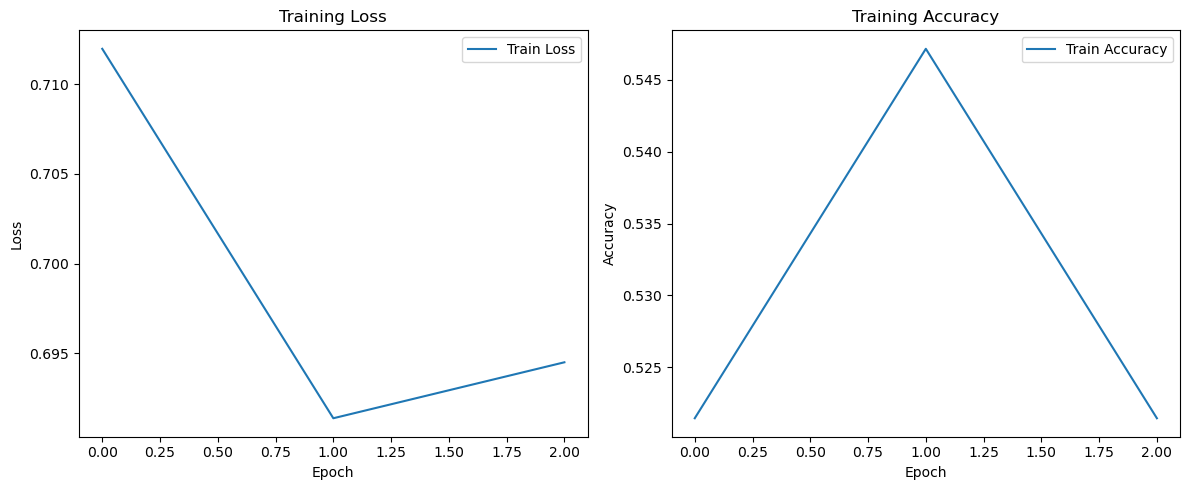

In [18]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
print("Train label distribution:", train_df[target_col].value_counts())
print("Val label distribution:", val_df[target_col].value_counts())
print("Test label distribution:", test_df[target_col].value_counts())